In [1]:
import pandas as pd
import numpy as np

In [2]:
import sympy as sp

In [3]:
import seaborn as sns

/home/m/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from scipy import stats

In [5]:
from numba import jit

# Overview

Given a trading system model $F_{t}(\theta)$, the goal is to adjust the parameters $\theta$ in order to maximise $U_{t}$ (wealth).

$$ \frac{dU_{T}(\theta)}{d\theta} = 
\sum \limits _{t=1} ^ {T} 
\frac{dU_{T}}{dR_{t}} 
\{ \frac{dR_{t}}{dF_{t}} \frac{dF_{t}}{d\theta} + \frac{dR_{t}}{dF_{t-1}} \frac{dF_{t-1}}{d\theta}  \}$$

Where:
* $U$ = wealth function (Sharpe ratio / Sterling ratio)
* $R_{t}$ = returns  
* $F_{t}$ = position  
* $\theta$ = model weights

References

J. Moody and M. Saffell, "Learning to trade via direct reinforcement," in IEEE Transactions on Neural Networks, vol. 12, no. 4, pp. 875-889, July 2001, doi: 10.1109/72.935097.

http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf

-----

In [6]:
N = 1/100
NUM_RETURNS = M = 15
FEE = 0.02

# Helper functions

In [7]:
def get_normalised_returns(n=500):
    df = pd.read_csv('~/Downloads/coinbaseGBP.csv', 
                 names=['_dt', 'price', 'size'])

    df['dt'] = pd.to_datetime(df['_dt'],unit='s')
    df = df.set_index('dt').drop(columns=['_dt'])

    #df['ret'] = np.log(df.price) - np.log(df.price.shift(1))
    df['ret'] = df['price'].pct_change()

    df = df.tail(n)
    
    rets_z = stats.zscore(df.ret.values)
    rets = np.tanh(rets_z)
    return rets

State takes the form: $[1, R_{t}, R_{t-1}, ..., R_{t-M}, F_{t-1}]$

In [8]:
def positions(rets, weights):
    '''
    Apply weights to state to determine positisons
    '''
    
    T = len(rets)
    pos = np.zeros(T)
    for t in range(M, T):
        state = np.concatenate([ [1], rets[t - M:t], [pos[t-1]] ])
        pos[t] = np.tanh(np.dot(weights, state))
        
    return pos

In [9]:
def returns(positions, rets, fee):
    '''
    Calculate realised returns based on positions and fees
    '''
    T = len(rets)
    rets = (positions[0:T-1] * rets[1:T]) - fee * (np.abs(positions[1:T] - positions[0:T-1]))
    return np.concatenate([[0], rets])

# Derivatives for gradient ascent

# $$ \frac{dU_{T}(\theta)}{d\theta} = 
\sum \limits _{t=1} ^ {T} 
\frac{dU_{T}}{dR_{t}} 
\{ \frac{dR_{t}}{dF_{t}} \frac{dF_{t}}{d\theta} + \frac{dR_{t}}{dF_{t-1}} \frac{dF_{t-1}}{d\theta}  \}$$

----

## $$\frac{dU_{T}}{dR_{t}} $$  
  
  

The *Sterling Ratio* is used as a wealth function:

$$ U_{t} = SterlingRatio = \frac{Annualized Average Return}{Maximum Drawdown}$$  
  
  
  


  
This has been approximated to the Downside Deviation Ratio (DDR):

$$ DDR_{T} = \frac{Average(R_{t})}{DD_{T}} $$

Where $$DD_{T} = (\frac{1}{T}\sum \limits _{t=1} ^ {T} min \{R_{t},0\}^2)^\frac{1}{2} $$

#### Approximated for online learning as:

Exponential moving average of returns:
$$A_{t} = A_{t-1} + n(R_{t} - A_{t-1})$$

In [10]:
def A(ret):
    T = len(ret)
    A = np.zeros(T)
    
    for t in range(NUM_RETURNS, T):
        A[t] = A[t-1] + (N * (ret[t] - A[t-1]))
        
    return A

Exponential moving average of squared drawdown: 
$$DD_{t}^2 = DD_{t-1}^2 + n(min(R_{t},0)^2 - DD_{t-1}^2)$$

In [11]:
def DD(ret):
    T = len(ret)
    DD = np.zeros(T)
    for t in range(NUM_RETURNS, T):
        DD[t] = DD[t-1] + (N * (min(ret[t],0)**2 - DD[t-1]))
        
    return DD

Combined to produce the Differential Downside Deviation Ratio (DDR):

$$D_{t} = \frac{DD_t^2{-1} \cdot (R_{t} - \frac{1}{2} A_{t-1}) - \frac{1}{2} A_{t-1}R_{t}^2}{DD_{t-1}^3} $$

#### Differential downside deviation ratio 

In [25]:
import sympy as sp

dd_t_1, rt, A_t_1 = sp.symbols('dd_t_-1, rt, A_t_-1')
Dt = (dd_t_1**2 * (rt - 0.5*A_t_1) - (0.5*A_t_1*rt**2)) / dd_t_1**3

display('Differential downside deviation ratio (Dt):', Dt)

dDdR = sp.diff(Dt, rt)
display('Partial derivative of Dt with respect to Rt:', dDdR)

'Differential downside deviation ratio (Dt):'

(-0.5*A_t_-1*rt**2 + dd_t_-1**2*(-0.5*A_t_-1 + rt))/dd_t_-1**3

'Partial derivative of Dt with respect to Rt:'

(-1.0*A_t_-1*rt + dd_t_-1**2)/dd_t_-1**3

In [13]:
sterling_ratio = lambda r: np.mean(r) / min(r)

In [14]:
def dUdR(a, t, r, dd):
    return ((-1*a[t-1]*r[t]) + dd[t-1]) / dd[t-1]

-------

## $$\frac{dR_{t}}{dF_{t}} = -\mu\delta \cdot sgn(F_{t} - F_{t-1})$$

In [15]:
def dRdFt(delta, Ft, t):
    return -delta * np.sign(Ft[t] - Ft[t-1])

-----

## $$\frac{dF_{t}}{d\theta} = (1-tanh(\theta^Tx_{t})^2) \cdot \{ x_{t} + w_{M+2} \frac{dF_{t-1}}{d\theta} \}$$

In [16]:
def dFtdTheta(Ft, t, rets, theta, prev):
    return (1 - Ft[t] ** 2) * (rets[t] + theta[-1] * prev)  

------

## $$\frac{dR_{t}}{dF_{t-1}} = \mu.r_{t} + \mu\delta \cdot sgn(F_{t}-F_{t-1})$$

In [17]:
def dRdFtp(rets, delta, Ft, t):
    return rets[t] + delta * np.sign(Ft[t] - Ft[t-1])

-----

In [18]:
def gradient(rets, weights, fee):
    pos = positions(rets, weights) 
    r = returns(pos, rets, FEE) 
   
    # I don't think i need to calc this for all time here, 
    # just N where n = (1/N)
    a = A(r)
    dd = DD(r)
    
    return _gradient(rets, pos, a, dd, fee), sterling_ratio(r)
    
def _gradient(rets, pos, a, dd, fee):
    T = len(rets)
    grad = np.zeros(M + 2)
    dFpdtheta = np.zeros(M + 2)

    for t in range(M, T):
        state = np.concatenate([ [1], rets[t - M:t], [pos[t-1]] ])
        
        _dUdR = dUdR(a, t, rets, dd)
        
        _dRdFt = dRdFt(fee, pos, t)
        _dRFtp = dRdFtp(rets, fee, pos, t)
        
        _dFdtheta = dFtdTheta(pos, t, rets, weights, dFpdtheta) 
        dFpdtheta = _dFdtheta
        
        inner = ( (_dRdFt * _dFdtheta) + (_dRFtp * dFpdtheta) )
        grad = grad + np.nan_to_num(_dUdR * inner)
        
    return grad



In [19]:
%%time 

epochs = 5000
lr = 0.05
weights = np.random.normal(loc=0, scale=1, size=M+2)-1
best_weights = np.zeros(M+2)

rets = get_normalised_returns()

ddrs = []
for i in range(0, epochs):
    g, ddr = gradient(rets, weights, FEE)
    weights = weights + (lr * g)
    
    ddrs.append(ddr)
    if ddr == max(ddrs):
        best_weights = weights
    
    if i % 1000 == 0:
        print(ddr, g[0])

/home/m/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.030387172094177 10.662966140619837
0.03683403159609589 1.2365515899495936
0.03682728098953433 1.1287143563891606
0.03678034248366528 1.0267094887606971
0.036693867287041486 0.9252354770388297
0.03649586272109285 0.863026770715192
0.03625230361696545 0.8331575417273649
0.036186359921093134 0.8648834271526583
0.03651728790076374 0.9299660418537741
0.0374371463559088 0.8891973809242099
0.0373196166226877 0.8801691074768832
0.03436581647074232 -7.520532004499808
-0.009604765137864648 0.29637842066870373
-0.009059482454185953 0.08921467010341484
-0.008355385524548889 0.08369527973093828
-0.007326437636115424 0.0815789860494289
-0.0062980294867744264 0.0793095572372224
-0.0056323320074318905 0.07758555239761092
-0.005236047695767724 0.07777444691547031
-0.004885156456457858 0.0798301176368451
-0.004461342500465378 0.08352115112154554
-0.003929803293583605 0.088858244559073
-0.0033050102947060934 0.09606706340626159
-0.002637136216055731 0.10585954558575526
-0.0019857370369432514 0.11942159

In [20]:
Ft = positions(rets, best_weights)

<AxesSubplot:>

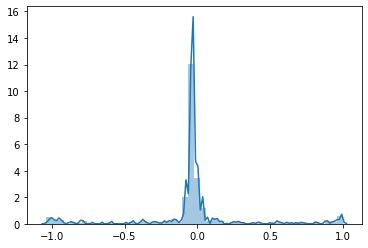

In [21]:
realised_returns = returns(Ft, rets, 0.02)
sns.distplot(realised_returns)

In [22]:
np.mean(realised_returns[np.where(realised_returns!=0)])

-0.04142222059078855

<AxesSubplot:>

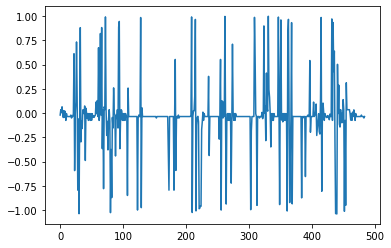

In [23]:
pd.Series(realised_returns[np.where(realised_returns!=0)]).plot()